## Assigment: Neural network basics

Soft deadline: 16.09.18 at 23.59

Hard deadline: 18.09.18 at 23.59

For this task I intentionally provide no boilerplate code, because very puprpose of this task is getting you comforatable with basic code template for desiging NNs in pytorch. I higly recommend you to revisit all the last seminar materials.

#### Task

* Implement simple **fully-convolutional** neural architecture for classification. Make sure it is small enought to run on your home machine.
* Provide dataset visulization.
* Provide train/test split and validation

#### Requirements

* Architecture should derive from `torch.nn.Module`
* Use `torch.utils.data.Dataset` and `torch.utils.data.DataLoader`. But if you manage co simplify this step using dataset `torchivision`, I will only encourage you.
* Implement at least one data transformer, but make sure it is useful for classification task.
* Use FashionMNIST dataset https://github.com/zalandoresearch/fashion-mnist
* Make sure you can fix random seed for all components of your code to make experiments reproducible
* Since you architecure should be fully-convolutional, make sure it does not depend on input size.

In [102]:
import itertools
%matplotlib inline
import matplotlib.pyplot as plt

import torch
from torch import nn
import torchvision
import numpy as np
from IPython import display

In [106]:
N_CLASSES = 10
BATCH_SIZE = 512

In [113]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(6, 9, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(9, 4, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.fc = nn.Sequential(
            nn.Linear(4 * 7 * 7, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, N_CLASSES)
        )
        
    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1, 4 * 7 * 7)
        x = self.fc(x)
        return x

In [32]:
def vector_classes(classes):
    n = len(classes)
    vecs = torch.zeros(n, N_CLASSES)
    vecs[torch.arange(n), classes] = 1
    return vecs

In [155]:
plt.figure(figsize=(10, 5))

def plot_accuracy(train_loss, test_loss, train_dr, test_dr):
    plt.clf()
    plt.subplot(1, 2, 1)
    plt.title('Loss')
    plt.plot(train_loss, label='Train')
    plt.plot(test_loss, label='Test')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.title('Detection rate')
    plt.plot(train_dr, label='Train')
    plt.plot(test_dr, label='Test')
    plt.legend()
    display.clear_output(wait=True)
    display.display(plt.gcf())

<Figure size 720x360 with 0 Axes>

In [176]:
def pass_data(net, data, optimizer, loss_function, training):
    losses = []
    correct_predictions, total_predictions = 0, 0
    for pix, classes in data:
        out = net(pix)
        correct_predictions += torch.sum(out.argmax(dim=1) == classes).item()
        total_predictions += len(classes)
        loss = loss_function(out, vector_classes(classes))
        losses.append(loss.item())
        if training:
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
    mean_loss = np.mean(losses)
    detection_rate = correct_predictions / total_predictions
    return mean_loss, detection_rate

def train(net, training_data, testing_data, epochs, lr):
    optim = torch.optim.SGD(net.parameters(), lr=lr)
    mse = nn.MSELoss()
    train_loss = np.zeros(epochs, dtype=np.float64)
    test_loss = np.zeros(epochs, dtype=np.float64)
    train_dr = np.zeros(epochs, dtype=np.float64)
    test_dr = np.zeros(epochs, dtype=np.float64)
    for i in range(epochs):
        train_loss[i], train_dr[i] = pass_data(net, training_data, optim, mse, True)
        test_loss[i], test_dr[i] = pass_data(net, testing_data, optim, mse, False)
        plot_accuracy(train_loss, test_loss, train_dr, test_dr)

In [185]:
def visualize_data(data_loader, rows, cols):
    batches = (rows * cols + BATCH_SIZE - 1) // BATCH_SIZE
    images = torch.cat([i[0] for i in itertools.islice(iter(data_loader), batches)])[:(rows * cols)]
    pic = torchvision.utils.make_grid(images, nrow=cols)
    plt.imshow(np.transpose(pic.numpy(), (1, 2, 0)))

In [186]:
torch.manual_seed(3)

In [159]:
pic_transform = torchvision.transforms.ToTensor()
train_set = torchvision.datasets.FashionMNIST(root='./data', download=True, transform=pic_transform, train=True)
test_set = torchvision.datasets.FashionMNIST(root='./data', download=True, transform=pic_transform, train=False)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, num_workers=1, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE, num_workers=1, shuffle=True)

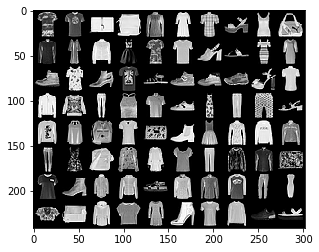

In [184]:
visualize_data(train_loader, 8, 10)

In [180]:
net = Net()

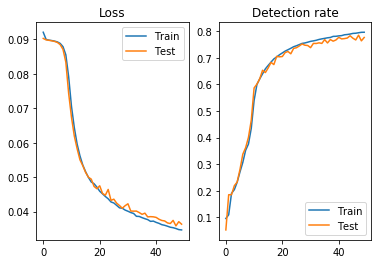

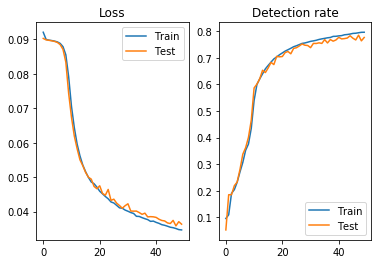

In [181]:
train(net, train_loader, test_loader, 50, 0.05)
torch.save(net.state_dict(), 'net.pth')